# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events
import pickle

In [2]:
# Import Modules
# import libcbm
# from util_walter import run_cbm, cbm_report, plugin_c_curves, compare_ws3_cbm

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'redchris'

## Create and Run `ForestModel` instance

In [4]:
# Creat Forest Model Instance for Timber Supply Area 24
fm = ws3.forest.ForestModel(model_name='redchris',
                            model_path='./data/woodstock_model_files_redchris',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

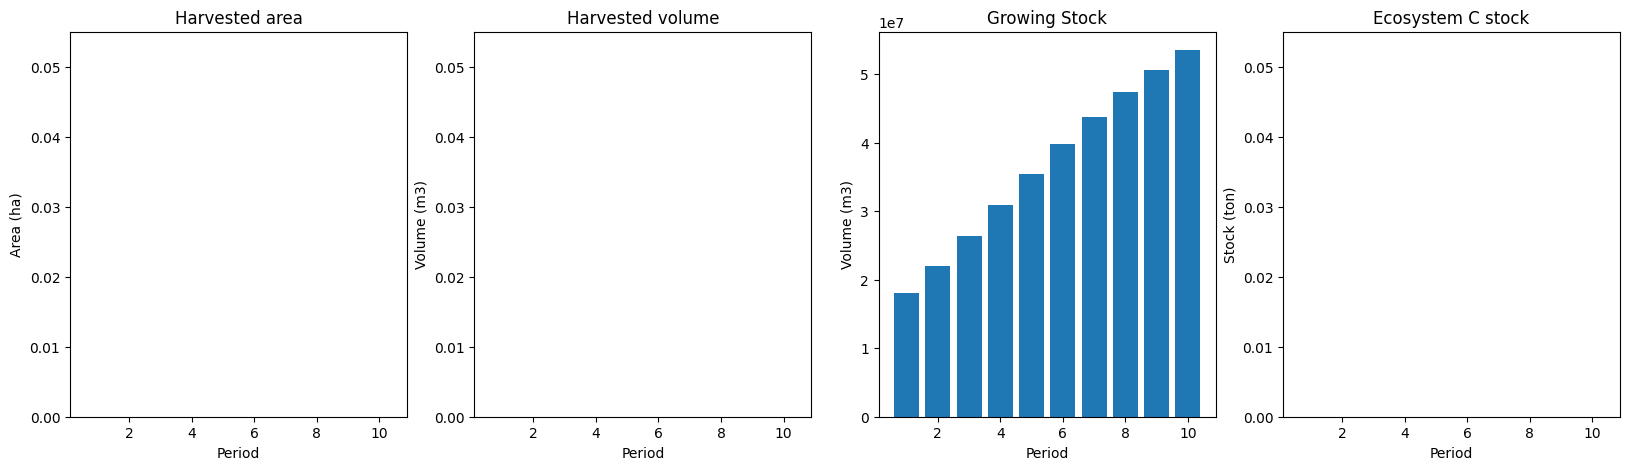

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[5] == dtype_key[4] else 'harvest'

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                        disturbance_type_mapping=disturbance_type_mapping)

In [8]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 
from libcbm.model.cbm.cbm_output import CBMOutput
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator
sit_data = sit_reader.parse(sit_classifiers=sit_tables['sit_classifiers'],
                            sit_disturbance_types=sit_tables['sit_disturbance_types'],
                            sit_age_classes=sit_tables['sit_age_classes'],
                            sit_inventory=sit_tables['sit_inventory'],
                            sit_yield=sit_tables['sit_yield'],
                            sit_events=sit_tables['sit_events'],
                            sit_transitions=sit_tables['sit_transitions'],
                            sit_eligibilities=None)
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)
cbm_output = CBMOutput(classifier_map=sit.classifier_value_names,
                       disturbance_type_map=sit.disturbance_name_map)
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(cbm,
                           n_steps=n_steps,
                           classifiers=classifiers,
                           inventory=inventory,
                           pre_dynamics_func=rule_based_processor.pre_dynamics_func,
                           reporting_func=cbm_output.append_simulation_result,
                           backend_type=BackendType.numpy)
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

In [9]:
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
ecosystem_pools = biomass_pools + dom_pools
# all_pools = biomass_pools + dom_pools + emissions_pools
all_pools = biomass_pools + dom_pools

In [10]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [11]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [12]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']

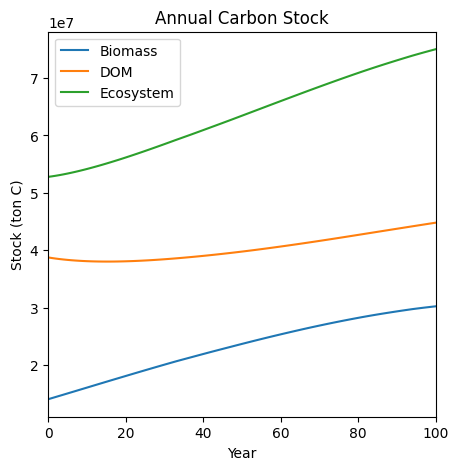

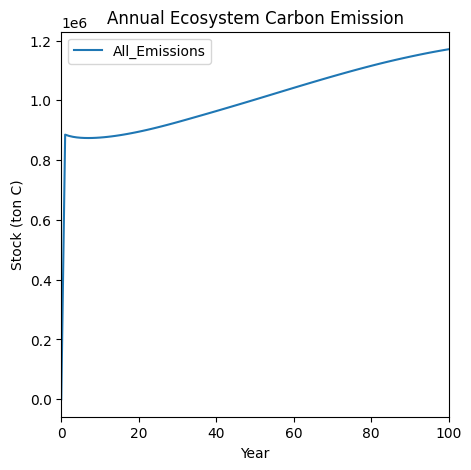

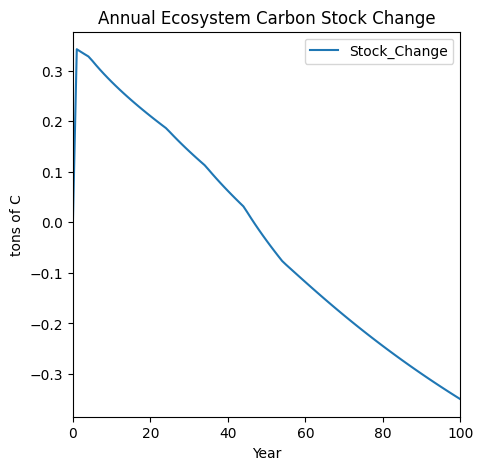

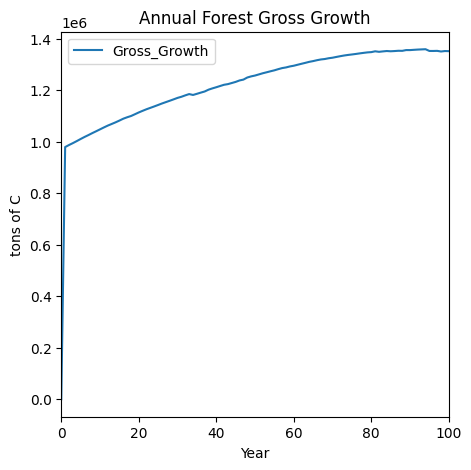

In [13]:
# Report Annual CBM Results
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Generate and Add Carbon Yield Curves

Carbon in product pools is considered a 100% immediate emission after harvesting activities.

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [14]:
sit_tables['sit_events']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [15]:
sit_tables['sit_inventory']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,0,1,304,1,1,softwood,FALSE,2,8742.827683,0,0,fire,fire
1,tsa04,0,1,304,1,1,softwood,FALSE,56,29.340691,0,0,fire,fire
2,tsa04,0,1,304,1,1,softwood,FALSE,63,38.722559,0,0,fire,fire
3,tsa04,0,1,304,1,1,softwood,FALSE,66,104.486862,0,0,fire,fire
4,tsa04,0,1,304,1,1,softwood,FALSE,70,27.409778,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3662,tsa04,1,42,1201,42,42,hardwood,FALSE,124,15.389482,0,0,fire,fire
3663,tsa04,1,42,1201,42,42,hardwood,FALSE,125,10.101145,0,0,fire,fire
3664,tsa04,1,42,1201,42,42,hardwood,FALSE,138,13.528389,0,0,fire,fire
3665,tsa04,1,42,1201,42,42,hardwood,FALSE,156,46.826669,0,0,fire,fire


In [16]:
# Set Age and Area to 0 and 1.0
df = sit_tables['sit_inventory']
df['age'] = df['age'].apply(lambda x: 0)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

In [17]:
df

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,0,1,304,1,1,softwood,FALSE,0,1.0,0,0,fire,fire
1,tsa04,0,2,304,2,2,softwood,FALSE,0,1.0,0,0,fire,fire
2,tsa04,0,3,304,3,3,softwood,FALSE,0,1.0,0,0,fire,fire
3,tsa04,0,4,204,4,4,softwood,FALSE,0,1.0,0,0,fire,fire
4,tsa04,0,5,204,5,5,softwood,FALSE,0,1.0,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,tsa04,1,38,100,38,38,softwood,FALSE,0,1.0,0,0,fire,fire
60,tsa04,1,39,100,39,39,softwood,FALSE,0,1.0,0,0,fire,fire
61,tsa04,1,40,1201,40,40,hardwood,FALSE,0,1.0,0,0,fire,fire
62,tsa04,1,41,1201,41,41,hardwood,FALSE,0,1.0,0,0,fire,fire


Use the following code if any of the developments have no harvesting circumstances.

In [18]:
# df_sub = df.loc[(df['theme1'] == 1) & (df['last_pass_disturbance'] == 'fire')]
# df_sub['theme4'] = df_sub['theme4'].apply(lambda x: x + 20000)
# df_sub['last_pass_disturbance'] = df_sub['last_pass_disturbance'].apply(lambda x: 'harvest')
# df_sub
# df = pd.concat([df, df_sub], ignore_index=True)
# df = df.drop_duplicates(ignore_index=True)
# df

In [19]:
# Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [20]:
# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

In [21]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [22]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,Input,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa04,0,1,304,1,1,softwood,1.0,...,46.804448,28.616202,19.461734,0.000000,0.000000,3758.314120,4.582231,41.238806,0.0,0.0
1,2,0,tsa04,0,2,304,2,2,softwood,1.0,...,52.788135,36.275304,20.645043,0.000000,0.000000,4235.506106,5.006031,45.052911,0.0,0.0
2,3,0,tsa04,0,3,304,3,3,softwood,1.0,...,61.447035,44.569275,21.902875,0.000000,0.000000,4914.728749,5.519610,49.674996,0.0,0.0
3,4,0,tsa04,0,4,204,4,4,softwood,1.0,...,58.532275,36.921375,20.743836,0.000000,0.000000,4659.762632,5.213501,46.920073,0.0,0.0
4,5,0,tsa04,0,5,204,5,5,softwood,1.0,...,58.167080,35.627738,20.545870,0.000000,0.000000,4624.849153,5.158699,46.426864,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,60,100,tsa04,1,38,100,38,38,softwood,1.0,...,62.902144,2.824887,1.524192,0.000000,0.000000,5597.831876,6.143316,55.288261,0.0,0.0
6460,61,100,tsa04,1,39,100,39,39,softwood,1.0,...,67.830777,3.425421,1.599357,0.000000,0.000000,6054.429894,6.617676,59.557429,0.0,0.0
6461,62,100,tsa04,1,40,1201,40,40,hardwood,1.0,...,76.929290,0.000000,0.000000,1.347705,1.494253,7077.041490,6.662725,59.962598,0.0,0.0
6462,63,100,tsa04,1,41,1201,41,41,hardwood,1.0,...,78.302050,0.000000,0.000000,1.350950,1.495755,7174.379336,6.680903,60.126192,0.0,0.0


In [23]:
fi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,DisturbanceCO2Production,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,tsa04,0,1,304,1,1,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,tsa04,0,2,304,2,2,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,tsa04,0,3,304,3,3,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,tsa04,0,4,204,4,4,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,tsa04,0,5,204,5,5,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,60,100,tsa04,1,38,100,38,38,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6460,61,100,tsa04,1,39,100,39,39,softwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6461,62,100,tsa04,1,40,1201,40,40,hardwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6462,63,100,tsa04,1,41,1201,41,41,hardwood,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [25]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [26]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0          0.000000e+00         0.000000       0.000000   
                  1          1.933007e-10         0.000071       0.000000   
                  2          8.648289e-09         0.000562       0.000000   
                  3          7.989637e-08         0.001891       0.000000   
                  4          3.869269e-07         0.004474       0.000000   
...                                   ...              ...            ...   
tsa04 1 9 100 9 9 96         2.104098e+01         4.745037      20.358906   
                  97         2.175800e+01         4.795649      20.486371   
                  98         2.247182e+01         4.845822      20.612979   
                  99         2.318258e+01         4.895558      20.738762   
                  100        2.389041e+01         4.944861      20.863748   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa04 0 1 304 1 1 0                    0.000000           0.000000   
                  1                    0.000009           0.000007   
                  2                    0.000072           0.000053   
                  3                    0.000241           0.000179   
                  4                    0.000570           0.000423   
...                                         ...                ...   
tsa04 1 9 100 9 9 96                   8.450468           1.793706   
                  97                   8.639842           1.803043   
                  98                   8.828619           1.811979   
                  99                   9.016810           1.820543   
                  100                  9.204425           1.828757   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
tsa04 1 9 100 9 9 96                  0.0              0.0            0.0   
                  97                  0.0              0.0            0.0   
                  98                  0.0              0.0            0.0   
                  99                  0.0              0.0            0.0   
                  100                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa04 0 1 304 1 1 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
tsa04 1 9 100 9 9 96                        0.0                0.0  ...   
                  97                        0.0                0.0  ...   
                  98                        0.0                0.0  ...   
                  99                        0.0                0.0  ...   
                  100                       0.0                0.0  ...   

                            BelowGroundVeryFastSoil  AboveGroundFastSoil  \
dtype_key         timestep                                   

In [27]:
c_curves_f

DisturbanceCO2Production  \
dtype_key         timestep                             
tsa04 0 1 304 1 1 0                              0.0   
                  1                              0.0   
                  2                              0.0   
                  3                              0.0   
                  4                              0.0   
...                                              ...   
tsa04 1 9 100 9 9 96                             0.0   
                  97                             0.0   
                  98                             0.0   
                  99                             0.0   
                  100                            0.0   

                            DisturbanceCH4Production  DisturbanceCOProduction  \
dtype_key         timestep                                                      
tsa04 0 1 304 1 1 0                              0.0                      0.0   
                  1                              0.0                      0.0   
                  2                              0.0                      0.0   
                  3                              0.0                      0.0   
                  4                              0.0                      0.0   
...                                              ...                      ...   
tsa04 1 9 100 9 9 96                             0.0                      0.0   
                  97                             0.0                      0.0   
                  98                             0.0                      0.0   
                  99                             0.0                      0.0   
                  100                            0.0                      0.0   

                            DisturbanceBioCO2Emission  \
dtype_key         timestep                              
tsa04 0 1 304 1 1 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
tsa04 1 9 100 9 9 96                              0.0   
                  97                              0.0   
                  98                              0.0   
                  99                              0.0   
                  100                             0.0   

                            DisturbanceBioCH4Emission  \
dtype_key         timestep                              
tsa04 0 1 304 1 1 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
tsa04 1 9 100 9 9 96                              0.0   
                  97                              0.0   
                  98                              0.0   
                  99                              0.0   
                  100                             0.0   

                            DisturbanceBioCOEmission  DecayDOMCO2Emission  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0                              0.0             0.000000   
                  1                              0.0             2.979357   
                  2                              0.0             2.749185   
                  3                              0.0             2.559418   
                  4                              0.0             2.399090   
...                                              ...                  ...   
tsa04 1 9 100 9 9 96                             0.0             2.485532   
                  97                             0.0             2.5

In [28]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [29]:
# Generate carbon yield curves for net emission
c_curves_f['total_emissions'] = c_curves_f[fluxes].sum(axis=1)
c_curves_f['net_fluxes'] = c_curves_f[npp_fluxes+["TurnoverMerchLitterInput","TurnoverFolLitterInput","TurnoverOthLitterInput","TurnoverCoarseLitterInput","TurnoverFineLitterInput"]].sum(axis=1)-c_curves_f[decay_emissions_fluxes].sum(axis=1)

In [30]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0          0.000000e+00         0.000000       0.000000   
                  1          1.933007e-10         0.000071       0.000000   
                  2          8.648289e-09         0.000562       0.000000   
                  3          7.989637e-08         0.001891       0.000000   
                  4          3.869269e-07         0.004474       0.000000   
...                                   ...              ...            ...   
tsa04 1 9 100 9 9 96         2.104098e+01         4.745037      20.358906   
                  97         2.175800e+01         4.795649      20.486371   
                  98         2.247182e+01         4.845822      20.612979   
                  99         2.318258e+01         4.895558      20.738762   
                  100        2.389041e+01         4.944861      20.863748   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa04 0 1 304 1 1 0                    0.000000           0.000000   
                  1                    0.000009           0.000007   
                  2                    0.000072           0.000053   
                  3                    0.000241           0.000179   
                  4                    0.000570           0.000423   
...                                         ...                ...   
tsa04 1 9 100 9 9 96                   8.450468           1.793706   
                  97                   8.639842           1.803043   
                  98                   8.828619           1.811979   
                  99                   9.016810           1.820543   
                  100                  9.204425           1.828757   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
tsa04 1 9 100 9 9 96                  0.0              0.0            0.0   
                  97                  0.0              0.0            0.0   
                  98                  0.0              0.0            0.0   
                  99                  0.0              0.0            0.0   
                  100                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa04 0 1 304 1 1 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
tsa04 1 9 100 9 9 96                        0.0                0.0  ...   
                  97                        0.0                0.0  ...   
                  98                        0.0                0.0  ...   
                  99                        0.0                0.0  ...   
                  100                       0.0                0.0  ...   

                            MediumSoil  AboveGroundSlowSoil  \
dtype_key         timestep                                    
tsa04 0 1 3

In [31]:
c_curves_f

DisturbanceCO2Production  \
dtype_key         timestep                             
tsa04 0 1 304 1 1 0                              0.0   
                  1                              0.0   
                  2                              0.0   
                  3                              0.0   
                  4                              0.0   
...                                              ...   
tsa04 1 9 100 9 9 96                             0.0   
                  97                             0.0   
                  98                             0.0   
                  99                             0.0   
                  100                            0.0   

                            DisturbanceCH4Production  DisturbanceCOProduction  \
dtype_key         timestep                                                      
tsa04 0 1 304 1 1 0                              0.0                      0.0   
                  1                              0.0                      0.0   
                  2                              0.0                      0.0   
                  3                              0.0                      0.0   
                  4                              0.0                      0.0   
...                                              ...                      ...   
tsa04 1 9 100 9 9 96                             0.0                      0.0   
                  97                             0.0                      0.0   
                  98                             0.0                      0.0   
                  99                             0.0                      0.0   
                  100                            0.0                      0.0   

                            DisturbanceBioCO2Emission  \
dtype_key         timestep                              
tsa04 0 1 304 1 1 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
tsa04 1 9 100 9 9 96                              0.0   
                  97                              0.0   
                  98                              0.0   
                  99                              0.0   
                  100                             0.0   

                            DisturbanceBioCH4Emission  \
dtype_key         timestep                              
tsa04 0 1 304 1 1 0                               0.0   
                  1                               0.0   
                  2                               0.0   
                  3                               0.0   
                  4                               0.0   
...                                               ...   
tsa04 1 9 100 9 9 96                              0.0   
                  97                              0.0   
                  98                              0.0   
                  99                              0.0   
                  100                             0.0   

                            DisturbanceBioCOEmission  DecayDOMCO2Emission  \
dtype_key         timestep                                                  
tsa04 0 1 304 1 1 0                              0.0             0.000000   
                  1                              0.0             2.979357   
                  2                              0.0             2.749185   
                  3                              0.0             2.559418   
                  4                              0.0             2.399090   
...                                              ...                  ...   
tsa04 1 9 100 9 9 96                             0.0             2.485532   
                  97                             0.0             2.5

Curvs Calibration

In [32]:
c_curves_p = c_curves_p.iloc[:,-3:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for total ecosystem pools
c_curves_f = c_curves_f.iloc[:,-2:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for net carbon flux

In [33]:
c_curves_p

ecosystem    biomass         DOM
dtype_key         timestep                                   
tsa04 0 1 304 1 1 0         129.246888   0.000000  129.246888
                  1         126.178245   0.000089  126.178156
                  2         123.347255   0.000707  123.346548
                  3         120.712934   0.002380  120.710554
                  4         118.245657   0.005631  118.240026
...                                ...        ...         ...
tsa04 1 9 100 9 9 96        161.874783  58.080775  103.794008
                  97        163.218880  59.207395  104.011485
                  98        164.563497  60.328361  104.235137
                  99        165.908730  61.443885  104.464845
                  100       167.254671  62.554166  104.700505

[6464 rows x 3 columns]

In [34]:
# Check the total ecosystem stock change
c_curves_p['ecosystem'].diff()

dtype_key          timestep
tsa04 0 1 304 1 1  0                NaN
                   1          -3.068643
                   2          -2.830989
                   3          -2.634322
                   4          -2.467276
                                 ...   
tsa04 1 9 100 9 9  96          1.343670
                   97          1.344097
                   98          1.344617
                   99          1.345232
                   100         1.345941
Name: ecosystem, Length: 6464, dtype: float64

In [35]:
c_curves_f

total_emissions  net_fluxes
dtype_key         timestep                             
tsa04 0 1 304 1 1 0                0.000000    0.000000
                  1                3.068738   -3.068643
                  2                2.831661   -2.830989
                  3                2.636201   -2.634322
                  4                2.471062   -2.467276
...                                     ...         ...
tsa04 1 9 100 9 9 96               2.560098    1.343670
                  97               2.577839    1.344097
                  98               2.595332    1.344617
                  99               2.612581    1.345232
                  100              2.629592    1.345941

[6464 rows x 2 columns]

Use pickle.dump, c_pickle, pickle.load to store and reload curvest

In [36]:
pools_mdf = ['ecosystem', 'biomass', 'DOM']

In [37]:
c_curves_p

ecosystem    biomass         DOM
dtype_key         timestep                                   
tsa04 0 1 304 1 1 0         129.246888   0.000000  129.246888
                  1         126.178245   0.000089  126.178156
                  2         123.347255   0.000707  123.346548
                  3         120.712934   0.002380  120.710554
                  4         118.245657   0.005631  118.240026
...                                ...        ...         ...
tsa04 1 9 100 9 9 96        161.874783  58.080775  103.794008
                  97        163.218880  59.207395  104.011485
                  98        164.563497  60.328361  104.235137
                  99        165.908730  61.443885  104.464845
                  100       167.254671  62.554166  104.700505

[6464 rows x 3 columns]

In [38]:
# Plug carbon yield curves into forest model
# plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])
plugin_c_curves(fm, c_curves_p, pools=sum_pools)

found match for mask ('?', '?', '?', '?', '1', '1')
found match for mask ('?', '?', '?', '?', '2', '2')
found match for mask ('?', '?', '?', '?', '3', '3')
found match for mask ('?', '?', '?', '?', '4', '4')
found match for mask ('?', '?', '?', '?', '5', '5')
found match for mask ('?', '?', '?', '?', '6', '6')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?', '?', '?', '8', '8')
found match for mask ('?', '?', '?', '?', '9', '9')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '16', '16')
found match for mask ('?', '?', '?', '?', '17', '17')
found match for mask ('?', '?', '?', '?', '18', '18')
found match for mask ('?', '?', '?', '?', '19', '19')
found match for mask ('?', '?', '?', '?', '20', '20')
found match for mask ('?', '?', '?', '?', '21', '21')
found match for mask ('?', '?', '?', '?', '22'

In [39]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '7', '7'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7f6807ab9bd0>),
   ('ecosystem', <ws3.core.Curve at 0x7f67f9947e50>),
   ('biomass', <ws3.core.Curve at 0x7f67f829dd20>),
   ('DOM', <ws3.core.Curve at 0x7f67f829c4f0>)]),
 (('?', '?', '?', '?', '1', '1'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7f6807ab9c00>),
   ('ecosystem', <ws3.core.Curve at 0x7f67f9945270>),
   ('biomass', <ws3.core.Curve at 0x7f67f9944e80>),
   ('DOM', <ws3.core.Curve at 0x7f67f99443a0>)]),
 (('?', '?', '?', '?', '2', '2'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7f6807aba530>),
   ('ecosystem', <ws3.core.Curve at 0x7f67f9944070>),
   ('biomass', <ws3.core.Curve at 0x7f67f9944c70>),
   ('DOM', <ws3.core.Curve at 0x7f67f9945060>)]),
 (('?', '?', '?', '?', '3', '3'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7f6807abb8e0>),
   ('ecosystem', <ws3.core.Curve at 0x7f67f99440d0>),
   ('biomass', <ws3.core.Curve at 0x7f67f9944ac0>),
   ('DOM', <ws3.cor

In [40]:
with open(f'{case_study}_c_curves_p.pkl', 'wb') as file:
    pickle.dump(c_curves_p, file)

In [41]:
with open(f'{case_study}_c_curves_p.pkl', 'rb') as file:
    c_curves_p = pickle.load(file)

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

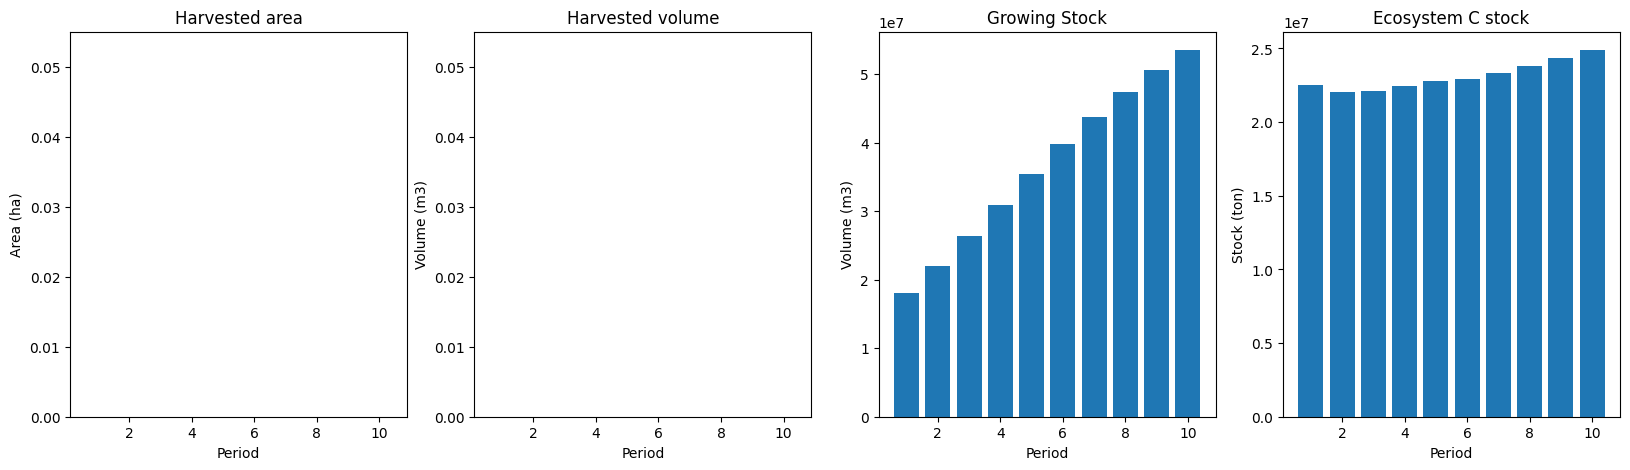

In [42]:
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

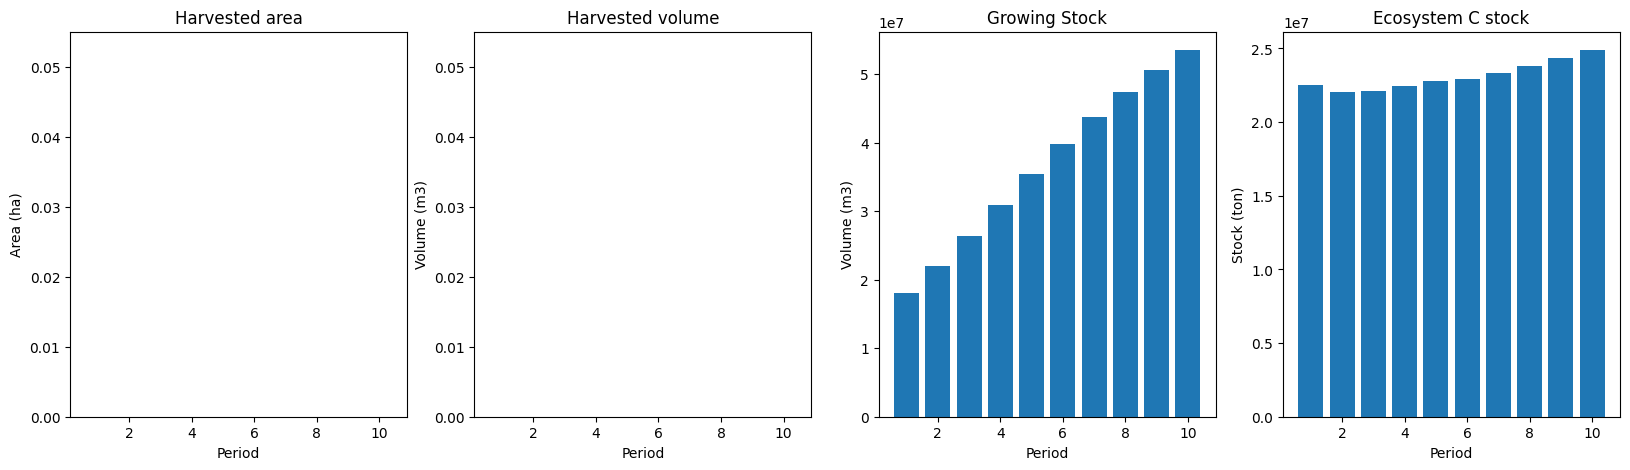

In [43]:
df = compile_scenario_maxstock(fm)
fig, ax = plot_scenario_maxstock(df)

In [44]:
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [45]:
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [46]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [47]:
sit_events

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [51]:

sit_tables['sit_inventory']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,0,1,304,1,1,softwood,FALSE,0,1.0,0,0,fire,fire
1,tsa04,0,2,304,2,2,softwood,FALSE,0,1.0,0,0,fire,fire
2,tsa04,0,3,304,3,3,softwood,FALSE,0,1.0,0,0,fire,fire
3,tsa04,0,4,204,4,4,softwood,FALSE,0,1.0,0,0,fire,fire
4,tsa04,0,5,204,5,5,softwood,FALSE,0,1.0,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,tsa04,1,38,100,38,38,softwood,FALSE,0,1.0,0,0,fire,fire
60,tsa04,1,39,100,39,39,softwood,FALSE,0,1.0,0,0,fire,fire
61,tsa04,1,40,1201,40,40,hardwood,FALSE,0,1.0,0,0,fire,fire
62,tsa04,1,41,1201,41,41,hardwood,FALSE,0,1.0,0,0,fire,fire


In [48]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

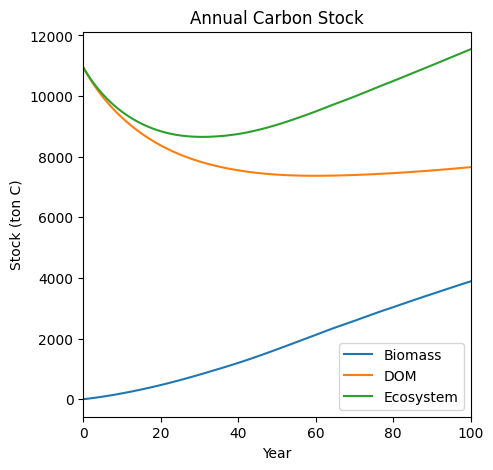

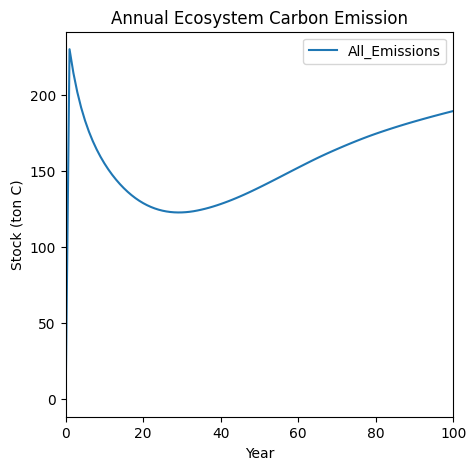

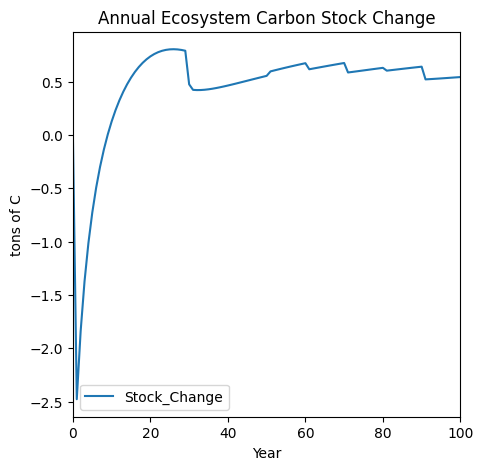

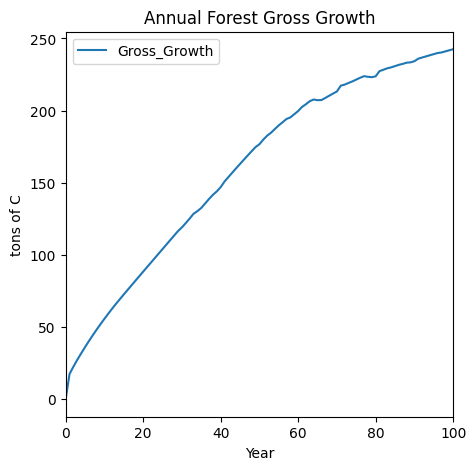

In [49]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

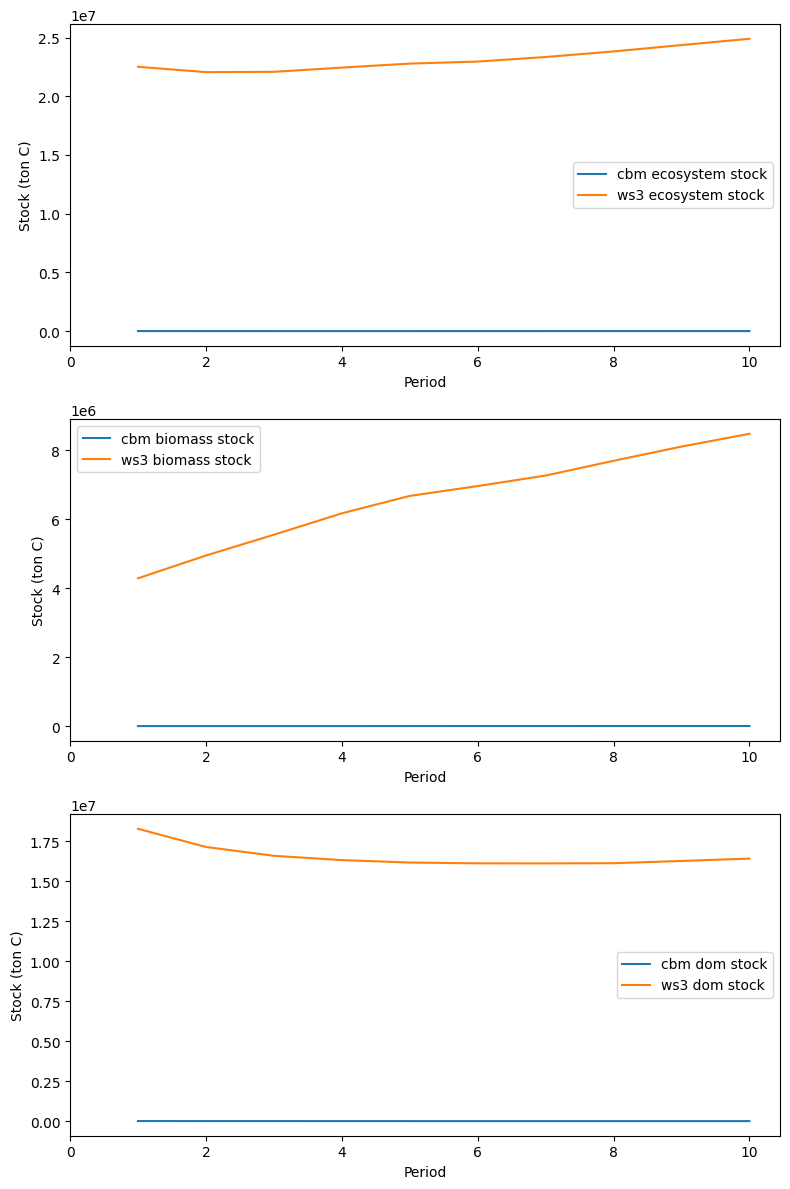

(   period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1      14.924813  10727.770921  10742.695734          0.000000
 1       2     216.858421   9177.724542   9394.582963      -1348.112771
 2       3     498.497837   8307.830184   8806.328020       -588.254942
 3       4     847.508093   7807.097970   8654.606063       -151.721957
 4       5    1239.408002   7532.085259   8771.493261        116.887197
 5       6    1690.740427   7402.154529   9092.894955        321.401695
 6       7    2170.284067   7372.281431   9542.565497        449.670542
 7       8    2632.542057   7402.318765  10034.860822        492.295324
 8       9    3080.209928   7467.523042  10547.732970        512.872149
 9      10    3512.359511   7557.036139  11069.395651        521.662681,
    period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   4.282666e+06  1.828646e+07  2.250758e+07          0.000000
 1       2   4.942505e+06  1.714938e+07  2.205397e+07    -45361

In [50]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
from util_opt import compare_ws3_cbm
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots="individual")